<a href="https://colab.research.google.com/github/yuli4ka/-infoSecurityLab3/blob/main/rectangleDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
num_images = 100000
num_rectangles = 1
image_size = 10
min_rectangle_size = 2
max_rectangle_size = 8

Creating dataset

In [3]:
images = np.zeros((num_images, image_size, image_size))
bound_boxes = np.zeros((num_images, num_rectangles, 4))

In [4]:
for i in range(num_images):
  for j in range(num_rectangles):
    w, h = np.random.randint(min_rectangle_size, max_rectangle_size, size=2)
    x0 = np.random.randint(0, image_size - w)
    y0 = np.random.randint(0, image_size - h)
    images[i, x0:x0+w, y0:y0+h] = 1
    bound_boxes[i, j] = [x0, y0, w, h]

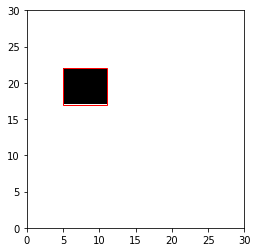

In [5]:
i = np.random.randint(0, num_images)
plt.imshow(images[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, image_size, 0, image_size])
for bound_box in bound_boxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bound_box[0], bound_box[1]), bound_box[2], bound_box[3], ec='r', fc='none'))

Reshaping and normalizing

In [6]:
images.shape, np.mean(images), np.std(images)

((100000, 30, 30), 0.07103195555555555, 0.2568782140344125)

In [7]:
X = images.reshape(num_images, -1)
X = (X - np.mean(images)) / np.std(images)

In [8]:
X.shape, np.mean(X), np.std(X)

((100000, 900), 8.967270383032478e-17, 0.9999999999999993)

In [9]:
bound_boxes.shape, np.mean(bound_boxes), np.std(bound_boxes)

((100000, 1, 4), 9.243795, 5.841082433759603)

In [10]:
Y = bound_boxes.reshape(num_images, -1)
Y = Y / image_size

In [11]:
Y.shape, np.mean(Y), np.std(Y)

((100000, 4), 0.3081265, 0.19470274779198674)

Get train and test set

In [12]:
i = int(num_images * 0.8)
x_train = X[:i]
y_train = Y[:i]
x_test = X[i:]
y_test = Y[i:]
test_images = images[i:]
test_boxes = bound_boxes[i:]

Train model

In [13]:
model = Sequential()

model.add(Dense(100, input_dim=X.shape[-1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(Y.shape[-1], activation='softmax'))

model.compile('adadelta', 'mse', metrics = ['acc'],)

In [14]:
epoch_num = 30
xc = range(epoch_num)

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0325 - acc: 0.5565 - val_loss: 0.0234 - val_acc: 0.6740


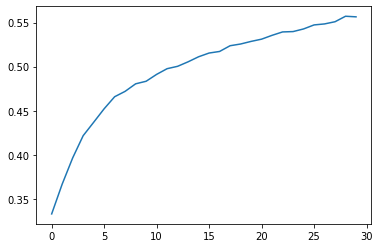

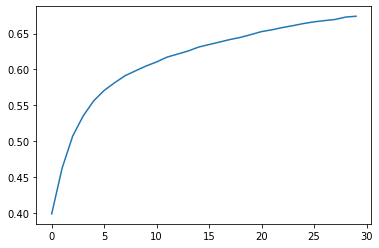

In [15]:
history = []
for i in range(epoch_num):
  history.append(model.fit(x_train, y_train, batch_size=50,validation_data=(x_test,y_test), epochs=1))
    
train_acc = []
for i in range(epoch_num):
  train_acc.append(history[i].history['acc'])
    
plt.figure()
plt.plot(xc, train_acc)

val_acc = []
for i in range(epoch_num):
  val_acc.append(history[i].history['val_acc'])

plt.figure()
plt.plot(xc, val_acc)

Check model

In [16]:
predicted_boxes = model.predict(x_test)
predicted_boxes = predicted_boxes * image_size
predicted_boxes = predicted_boxes.reshape(len(predicted_boxes), num_rectangles, -1)
predicted_boxes.shape

(20000, 1, 4)

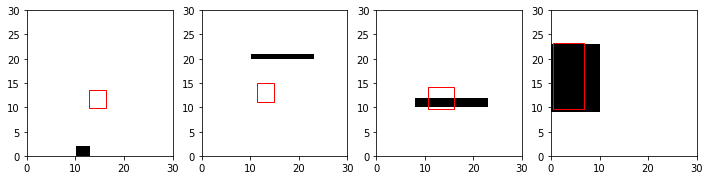

In [17]:
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_images))
    plt.imshow(test_images[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, image_size, 0, image_size])
    for pred_box, exp_bbox in zip(predicted_boxes[i], test_boxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3], ec='r', fc='none'))